# CLEVR VQA

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from tensorflow.data import AUTOTUNE
from tqdm import tqdm, trange
from transformers import AutoTokenizer, TFAutoModel

p = Path.home() / "clevr-vqa"

answer_values = [
    # Count
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10",
    # Binary
    "no",
    "yes",
    # Color
    "blue",
    "brown",
    "cyan",
    "gray",
    "green",
    "purple",
    "red",
    "yellow",
    # Shape
    "cylinder",
    "cube",
    "sphere",
    # Size
    "large",
    "small",
    # material
    "metal",
    "rubber",
]
# Note: the test set does not have answers so we fill with 255
answer_lut = {a.encode("utf8"): i for i, a in enumerate(answer_values)}
answer_lut[b""] = 255

# Set tf device and let it print its warnings
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[0], "GPU")
tf.ones([4]);

2022-05-19 15:40:30.373414: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 15:40:32.563229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10053 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


## BERT tokenizer and model

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
bert = TFAutoModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Dataset

Load training data, show some stats.

In [3]:
ds, info = tfds.load("clevr", split="train", with_info=True)

print(info.features)

for split in info.splits:
    print(split, info.splits[split])

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'objects': Sequence({
        '3d_coords': Tensor(shape=(3,), dtype=tf.float32),
        'color': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
        'material': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'pixel_coords': Tensor(shape=(3,), dtype=tf.float32),
        'rotation': tf.float32,
        'shape': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'size': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    'question_answer': Sequence({
        'answer': Text(shape=(), dtype=tf.string),
        'question': Text(shape=(), dtype=tf.string),
    }),
})
train <SplitInfo num_examples=70000, num_shards=128>
validation <SplitInfo num_examples=15000, num_shards=32>
test <SplitInfo num_examples=15000, num_shards=32>


In [4]:
@tf.function
def map_fn(sample):
    return {
        "file_name": sample["file_name"],
        "question": sample["question_answer"]["question"],
        "answer": sample["question_answer"]["answer"],
    }


ds = ds.map(map_fn, num_parallel_calls=AUTOTUNE)
df = pd.DataFrame(
    [
        (
            sample["file_name"],
            q,
            a,
        )
        for sample in tqdm(
            ds.as_numpy_iterator(), total=ds.cardinality().numpy(), ncols=0
        )
        for q, a in zip(sample["question"], sample["answer"])
    ],
    columns=["file_name", "question", "answer"],
)
df = df.apply(lambda s: s.values.astype(str))
df["answer"] = df["answer"].astype(pd.CategoricalDtype(answer_values, ordered=True))
df

100% 70000/70000 [00:26<00:00, 2654.30it/s]


,file_name,question,answer
0,CLEVR_train_043876.png,What is the color of the thing that is to the ...,blue
1,CLEVR_train_043876.png,There is a big gray metallic object; how many ...,2
2,CLEVR_train_043876.png,What number of other things are the same size ...,4
3,CLEVR_train_043876.png,What is the size of the brown rubber object th...,large
4,CLEVR_train_043876.png,What is the shape of the small metal thing on ...,cube
...,...,...,...
699984,CLEVR_train_034220.png,The small brown thing that is behind the tiny ...,sphere
699985,CLEVR_train_034220.png,What material is the block that is the same co...,metal
699986,CLEVR_train_034220.png,The ball that is to the left of the rubber bal...,yellow
699987,CLEVR_train_034220.png,Do the metal cube and the cyan cylinder have t...,no


In [5]:
print("Num images:", df["file_name"].nunique())
print()
print("Num questions:", df["question"].size)
print()
print(
    "Num questions per image:",
    df.groupby("file_name").size().value_counts(),
    sep="\n",
)

Num images: 70000

Num questions: 699989

Num questions per image:
10    69996
9         3
2         1
dtype: int64


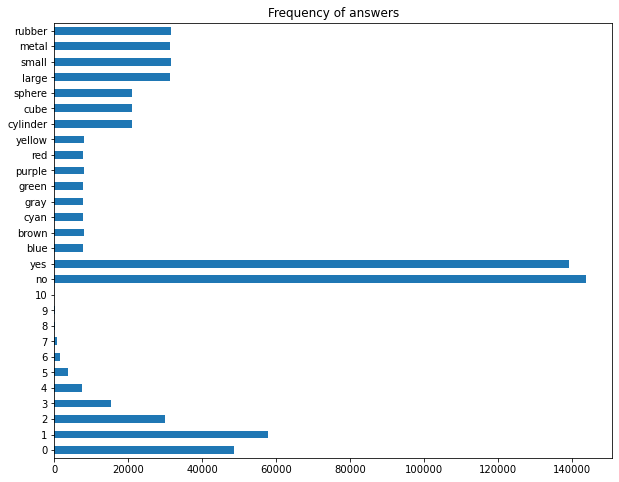

In [6]:
df["answer"].value_counts().sort_index().plot.barh(
    title="Frequency of answers", figsize=(10, 8)
);

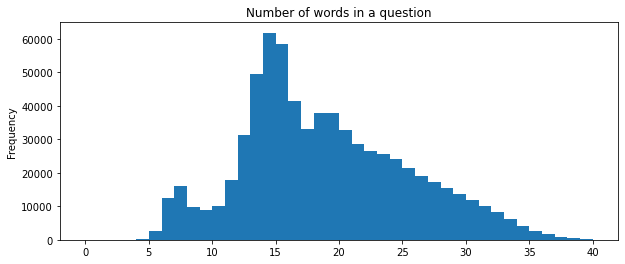

In [7]:
df["question"].str.split(" ").str.len().plot.hist(
    title="Number of words in a question", bins=np.arange(41), figsize=(10, 4)
);

In [8]:
questions = df["question"].tolist()
tokenized_questions = []

B = 10_000
for b in trange(0, len(questions), B, ncols=0):
    tokenized_questions.extend(
        tokenizer(
            questions[b : b + B],
            padding=False,
            add_special_tokens=True,
            truncation=False,
            return_attention_mask=False,
            return_tensors=None,
            return_token_type_ids=False,
        )["input_ids"]
    )

100% 70/70 [00:23<00:00,  3.04it/s]


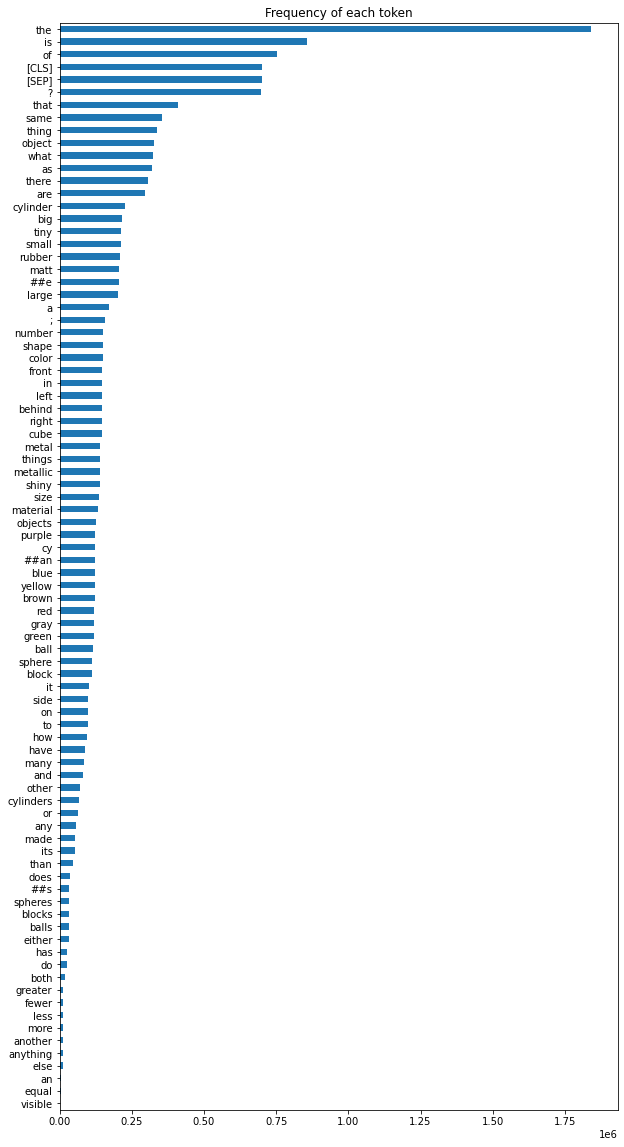

In [9]:
tkns = pd.Series(np.concatenate(tokenized_questions)).value_counts().sort_values()
tkns.index = tokenizer.convert_ids_to_tokens(tkns.index)
tkns.plot.barh(title="Frequency of each token", figsize=(10, 20));

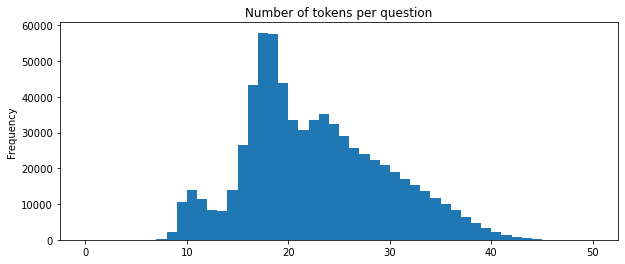

In [10]:
pd.Series([len(tkns) for tkns in tokenized_questions]).plot.hist(
    title="Number of tokens per question", bins=np.arange(51), figsize=(10, 4)
);

## One image

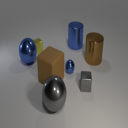

Q: What is the color of the thing that is to the left of the tiny yellow metallic object?
A: blue
Q: There is a big gray metallic object; how many brown objects are behind it?
A: 2
Q: What number of other things are the same size as the brown rubber thing?
A: 4
Q: What is the size of the brown rubber object that is the same shape as the yellow thing?
A: large
Q: What is the shape of the small metal thing on the left side of the brown matte block?
A: cube
Q: What is the color of the big metal thing that is in front of the sphere left of the gray metal ball?
A: gray
Q: What number of objects are large things that are left of the gray metal cube or small spheres?
A: 5
Q: There is a gray shiny sphere; is it the same size as the ball left of the big block?
A: yes
Q: How many large objects are either blue metallic things or blue cylinders?
A: 2
Q: What is the shape of the big brown matte object?
A: cube


In [11]:
@tf.function
def map_fn(sample):
    return {
        "image": sample["image"],
        "question": sample["question_answer"]["question"],
        "answer": sample["question_answer"]["answer"],
    }


sample = tfds.load("clevr", split="train").map(map_fn).take(1).get_single_element()
display(PIL.Image.fromarray(sample["image"].numpy()).resize((128, 128)))
for q, a in zip(
    sample["question"].numpy().astype(str), sample["answer"].numpy().astype(str)
):
    print("Q:", q)
    print("A:", a)

In [12]:
tkns = tokenizer(
    sample["question"].numpy().astype(str).tolist(),
    padding=True,
    add_special_tokens=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors="tf",
    return_token_type_ids=True,
)

hidden_states = bert.call(
    input_ids=tkns["input_ids"],
    token_type_ids=tkns["token_type_ids"],
    attention_mask=tkns["attention_mask"],
    output_hidden_states=True,
    return_dict=True,
    training=False,
)["hidden_states"]

encodings = tf.reduce_sum(hidden_states[-4:], axis=0)
encodings = encodings.numpy()
print("encodings:", *encodings.shape)

encodings: 10 25 768


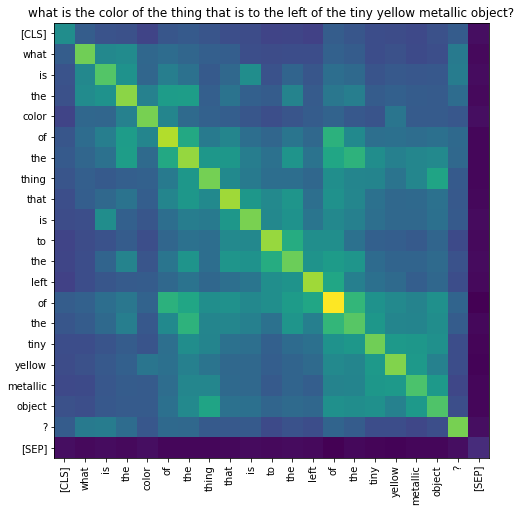

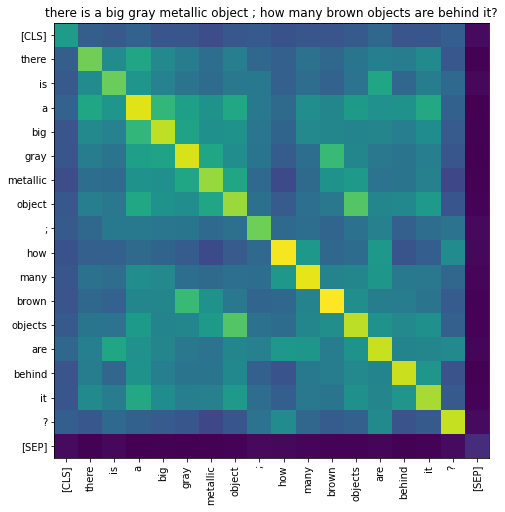

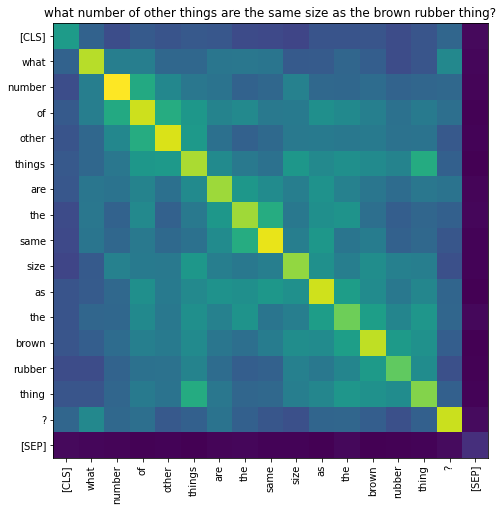

In [13]:
for b in range(3):
    num_tkns = tf.math.count_nonzero(tkns["attention_mask"][b], axis=-1)
    question = tokenizer.convert_ids_to_tokens(tkns["input_ids"][b, :num_tkns])
    enc = encodings[b, :num_tkns]
    dot = enc @ enc.T

    fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="white")
    ax.set_title(tokenizer.convert_tokens_to_string(question[1:-1]))
    ax.imshow(dot)
    ax.set_xticks(range(dot.shape[1]))
    ax.set_xticklabels(question, rotation=90)
    ax.set_yticks(range(dot.shape[0]))
    ax.set_yticklabels(question)
    display(fig)
    plt.close(fig)

## Full dataset

Process full dataset:
- input dict with image, question and answer strings, and object annotations
- tokenize and encode questions
- turn answers into int indexes
- encode as tfrecords

In [14]:
@tf.function
def map_fn(sample):
    question = sample["question_answer"]["question"]
    answer = sample["question_answer"]["answer"]
    # The N question and answers become ragged tensor with shape [N, 1],
    # The extra dim is needed because ragged tensors mush have rank >=2
    return {
        "image": sample["image"],
        "question": tf.RaggedTensor.from_tensor(question[:, None]),
        "answer": tf.RaggedTensor.from_tensor(answer[:, None]),
    }


@tf.function
def squeeze_ragged(batch):
    # After batching, question and answer have shape [B, (N), 1]
    # where N is ragged. The last dimension can be squeezed to [B, (N)].
    return {
        "image": batch["image"],
        "question": tf.squeeze(batch["question"], -1),
        "answer": tf.squeeze(batch["answer"], -1),
    }


batch_size = 64

ds = tfds.load("clevr", split="train").map(map_fn).batch(batch_size).map(squeeze_ragged)

How to deal with variable number of questions and variable question length?

In [15]:
# Find the batch that contains one sample that has fewer question than the others
for batch in tqdm(ds, ncols=0):
    if tf.reduce_any(
        batch["question"].row_lengths() != batch["question"].row_lengths()[0]
    ):
        break

# [B, (N)] where N is a variable number of questions per sample
print(
    "questions:",
    batch["question"].shape,
    batch["question"].bounding_shape().numpy(),
    batch["question"].dtype,
)

# tkns[input_ids|token_type_ids|attention_mask] have shape [BN, T]
# where BN = sum(len(q) for q in batch["question"])
# due to the flattening of the ragged shape [B, (N)]
# and T = max(len(tokenize(q)) for q in batch["question"])
# due to padding to the longest number of tokens.
tkns = tokenizer(
    batch["question"].flat_values.numpy().astype(str).tolist(),
    padding="longest",
    add_special_tokens=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors="tf",
    return_token_type_ids=True,
)

# BERT produces dense encodings with shape [BN, T, D]
hidden_states = bert.call(
    input_ids=tkns["input_ids"],
    token_type_ids=tkns["token_type_ids"],
    attention_mask=tkns["attention_mask"],
    output_hidden_states=True,
    return_dict=True,
)["hidden_states"]
question_enc = tf.reduce_sum(hidden_states[-4:], axis=0)
print("question_enc:", question_enc.shape, question_enc.dtype)

# Encodings are reshaped to [B, (N), (T), D]
# where N is the variable number of questions of each sample
# and T is the variable number of tokens of each questions
num_questions = batch["question"].row_lengths()
num_tkns_per_question = tf.math.count_nonzero(tkns["attention_mask"], axis=-1)

question_enc = tf.RaggedTensor.from_tensor(
    question_enc, lengths=[num_tkns_per_question]
)
question_enc = tf.RaggedTensor.from_row_lengths(question_enc, row_lengths=num_questions)
print(
    "question_enc:",
    question_enc.shape,
    question_enc.bounding_shape().numpy(),
    question_enc.dtype,
)

# Same thing for question tokens but they don't have the inner dimension D
question_tkn = tf.RaggedTensor.from_tensor(
    tkns["input_ids"], lengths=[num_tkns_per_question]
)
question_tkn = tf.RaggedTensor.from_row_lengths(question_tkn, row_lengths=num_questions)
print(
    "question_tkn:",
    question_tkn.shape,
    question_tkn.bounding_shape().numpy(),
    question_tkn.dtype,
)

# Map str answers to int indexes. The ragged tensor is first flattened and then shaped back.
print(
    "answer:",
    batch["answer"].shape,
    batch["answer"].bounding_shape().numpy(),
    batch["answer"].dtype,
)
answer = tf.RaggedTensor.from_row_splits(
    pd.Series(batch["answer"].flat_values.numpy())
    .map(answer_lut)
    .values.astype(np.uint8),
    batch["answer"].row_splits,
)
print("answer:", answer.shape, answer.bounding_shape().numpy(), answer.dtype)

 11% 119/1094 [00:03<00:26, 36.92it/s]


questions: (64, None) [64 10] <dtype: 'string'>
question_enc: (639, 41, 768) <dtype: 'float32'>
question_enc: (64, None, None, 768) [ 64  10  41 768] <dtype: 'float32'>
question_tkn: (64, None, None) [64 10 41] <dtype: 'int32'>
answer: (64, None) [64 10] <dtype: 'string'>
answer: (64, None) [64 10] <dtype: 'uint8'>


In [16]:
def serialize_sample(sample):
    feature = {
        "image": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[tf.io.serialize_tensor(sample["image"]).numpy()]
            )
        ),
        "question_splits": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[
                    tf.io.serialize_tensor(sample["question_enc"].row_splits).numpy()
                ]
            )
        ),
        "question_tkn_flat": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[
                    tf.io.serialize_tensor(sample["question_tkn"].flat_values).numpy()
                ]
            )
        ),
        "question_enc_flat": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[
                    tf.io.serialize_tensor(sample["question_enc"].flat_values).numpy()
                ]
            )
        ),
        "answer": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[tf.io.serialize_tensor(sample["answer"]).numpy()]
            )
        ),
    }
    return tf.train.Example(
        features=tf.train.Features(feature=feature)
    ).SerializeToString()


def deserialize_sample(sample):
    sample = tf.io.parse_single_example(
        sample,
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "question_splits": tf.io.FixedLenFeature([], tf.string),
            "question_tkn_flat": tf.io.FixedLenFeature([], tf.string),
            "question_enc_flat": tf.io.FixedLenFeature([], tf.string),
            "answer": tf.io.FixedLenFeature([], tf.string),
        },
    )
    image = tf.io.parse_tensor(sample["image"], tf.uint8)
    question_splits = tf.io.parse_tensor(sample["question_splits"], tf.int64)
    question_tkn = tf.io.parse_tensor(sample["question_tkn_flat"], tf.int32)
    question_tkn = tf.RaggedTensor.from_row_splits(question_tkn, question_splits)
    question_enc = tf.io.parse_tensor(sample["question_enc_flat"], tf.float32)
    question_enc = tf.RaggedTensor.from_row_splits(question_enc, question_splits)
    answer = tf.io.parse_tensor(sample["answer"], tf.uint8)
    return {
        "image": image,
        "question_tkn": question_tkn,
        "question_enc": question_enc,
        "answer": answer,
    }


# Check shapes before/after serialization
for b in range(16):
    s = serialize_sample(
        {
            "image": batch["image"][b],
            "question_tkn": question_tkn[b],
            "question_enc": question_enc[b],
            "answer": answer[b],
        }
    )
    s = deserialize_sample(s)
    print({k: tuple(v.shape) for k, v in s.items()})

{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10, None, 768), 'answer': (10,)}
{'image': (320, 480, 3), 'question_tkn': (10, None), 'question_enc': (10,

Process all splits

In [17]:
def prepare_samples(batch):
    tkns = tokenizer(
        batch["question"].flat_values.numpy().astype(str).tolist(),
        padding="longest",
        add_special_tokens=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
        return_token_type_ids=True,
    )
    num_questions = batch["question"].row_lengths()
    num_tkns_per_question = tf.math.count_nonzero(tkns["attention_mask"], axis=-1)

    hidden_states = bert.call(
        input_ids=tkns["input_ids"],
        token_type_ids=tkns["token_type_ids"],
        attention_mask=tkns["attention_mask"],
        output_hidden_states=True,
        return_dict=True,
    )["hidden_states"]

    question_enc = tf.reduce_sum(hidden_states[-4:], axis=0)
    question_enc = tf.RaggedTensor.from_tensor(
        question_enc, lengths=[num_tkns_per_question]
    )
    question_enc = tf.RaggedTensor.from_row_lengths(
        question_enc, row_lengths=num_questions
    )

    question_tkn = tf.RaggedTensor.from_tensor(
        tkns["input_ids"], lengths=[num_tkns_per_question]
    )
    question_tkn = tf.RaggedTensor.from_row_lengths(
        question_tkn, row_lengths=num_questions
    )

    answer = tf.RaggedTensor.from_row_splits(
        pd.Series(batch["answer"].flat_values.numpy())
        .map(answer_lut)
        .values.astype(np.uint8),
        batch["answer"].row_splits,
    )

    return [
        {
            "image": batch["image"][b],
            "question_tkn": question_tkn[b],
            "question_enc": question_enc[b],
            "answer": answer[b],
        }
        for b in range(batch["image"].shape[0])
    ]


batch_size = 64
samples_per_shard = 5000

for split in ["train", "validation", "test"]:
    ds = (
        tfds.load("clevr", split=split)
        .map(map_fn, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .map(squeeze_ragged, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    count = 0
    bar = tqdm(desc=split, ncols=0)
    for batch in ds:
        for sample in prepare_samples(batch):
            if count % samples_per_shard == 0:
                writer = str(p / f"{split}.{count//samples_per_shard}.tfrecords")
                writer = tf.io.TFRecordWriter(writer, options="GZIP")

            writer.write(serialize_sample(sample))
            count += 1
            bar.update()

            if count % samples_per_shard == 0:
                writer.close()

    bar.close()

train: 70000it [1:56:30, 10.01it/s]
validation: 15000it [24:42, 10.12it/s]
test: 15000it [24:56, 10.03it/s]


Test reads

In [53]:
for split in ["train", "validation", "test"]:
    ds = (
        tf.data.TFRecordDataset(
            list(map(str, p.glob(f"{split}.*.tfrecords"))),
            compression_type="GZIP",
        )
        .map(deserialize_sample, num_parallel_calls=AUTOTUNE)
        # This is necessary for stacking a batch of answers
        .map(
            lambda s: {
                **s,
                "answer": tf.RaggedTensor.from_tensor(s["answer"][:, None]),
            },
            num_parallel_calls=AUTOTUNE,
        )
        .batch(100, num_parallel_calls=AUTOTUNE)
        .map(
            lambda s: {**s, "answer": tf.squeeze(s["answer"], 2)},
            num_parallel_calls=AUTOTUNE,
        )
    )
    for batch in tqdm(ds, desc=split, unit_scale=100, ncols=0):
        pass

train: 70000it [07:38, 152.81it/s]
validation: 15000it [01:37, 154.62it/s]
test: 15000it [01:37, 153.82it/s]
